<a href="https://colab.research.google.com/github/arcrz28/Proyectos/blob/main/Clasificaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/Diplomado

/content/drive/MyDrive/Colab Notebooks/Diplomado


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D, Dropout,Activation,MaxPooling2D,Flatten
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from tensorflow.keras.preprocessing import image
import os
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from tensorflow.keras.utils import to_categorical

In [ ]:
!pip install wandb

# **Esta parte la hice en Wandb porque quería saber como iban las gráficas y si el código tenía un buen accuracy.**
Link: https://wandb.ai/arcecrz/Clasificaci%C3%B3n?nw=nwuserarcecrz06

In [ ]:
import wandb
#from wandb.keras import WandbCallback
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: arcecrz-06 (arcecrz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
batch_size=150
epochs=10
learning_rate=0.00025
loss='binary_crossentropy'
optimizer='adam'

In [ ]:

wandb.init(project="clasificación")
wandb.config.learning_rate = learning_rate
wandb.config.epochs = epochs
wandb.config.batch_size = batch_size
wandb.config.loss = loss
#wandb.config.optimizer = optimizer

In [ ]:
train_dir = 'Dataset/minitrain' #directorio de entrenamiento
test_dir = 'Dataset/minitest' #directorio de prueba

### Para saber cuantas imágenes hay
cat_files_path = os.path.join(train_dir, 'cat/*')
dog_files_path = os.path.join(train_dir, 'dog/*')

cat_files = sorted(glob(cat_files_path))
dog_files = sorted(glob(dog_files_path))

n_files = len(cat_files) + len(dog_files)
print(n_files)

cat_files_path_test = os.path.join(test_dir, 'cat/*')
dog_files_path_test = os.path.join(test_dir, 'dog/*')

cat_files_test = sorted(glob(cat_files_path_test))
dog_files_test = sorted(glob(dog_files_path_test))

n_files_test = len(cat_files_test) + len(dog_files_test)
print(n_files_test)

4000
1260


Found 4000 images belonging to 2 classes.
Found 1260 images belonging to 2 classes.


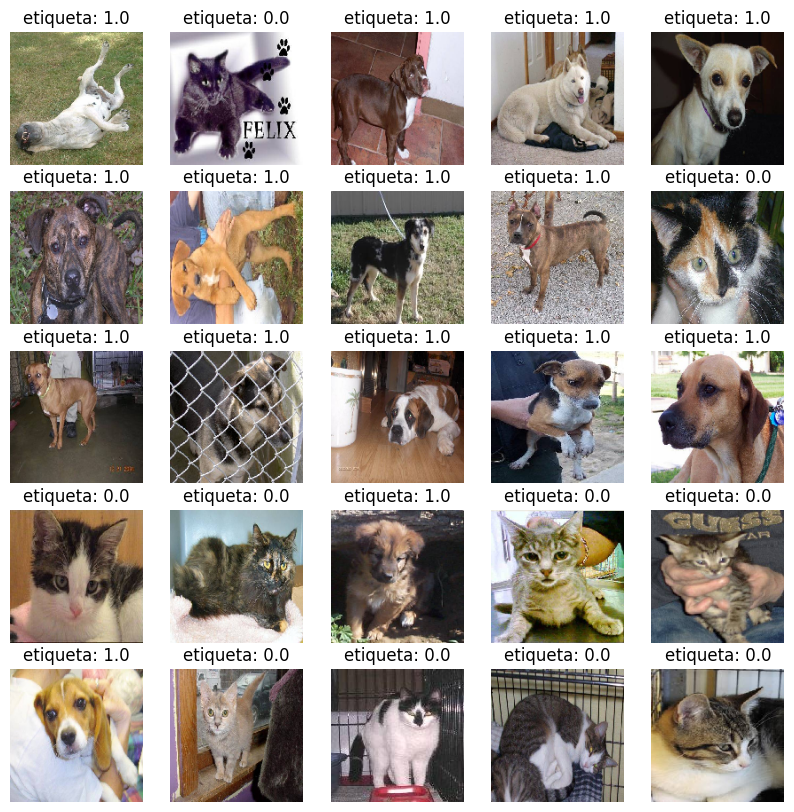

In [ ]:


train_dir = 'Dataset/minitrain'
test_dir = 'Dataset/minitest'
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')


plt.figure(figsize=(10,10))

for i, (X_train_batch, y_train_batch) in enumerate(train_generator):
    if i >= 25:  # Solo manda 25 imágenes
        break
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train_batch[0], cmap='gray')
    plt.title(f"etiqueta: {y_train_batch[0]}")
    plt.axis('off')

In [ ]:
#Redimensional las imágenes para incluir el canal CNN
#Las CNN esperan la información de la imagen que va a ser el alto, ancho y canales
train_dir = np.expand_dims(train_dir, -1) #Forma (60k, 28, 28, 1)
test_dir = np.expand_dims(test_dir, -1) #Forma (10k, 28, 28, 1)

In [ ]:
#convertir etiquetas a one-hot
#Ejemplo
#El 3 a one hot ---- [0,0,0,1, .......,0]
#el cero a one hot quedaría [1,0, .........., 0]
train_labels = np.array([0] * len(cat_files) + [1] * len(dog_files))  # 0 para gato, 1 para perro
test_labels = np.array([0] * len(cat_files_test) + [1] * len(dog_files_test))

train_labels_onehot = to_categorical(train_labels, num_classes=2)
test_labels_onehot = to_categorical(test_labels, num_classes=2)


In [ ]:
print("Nueva firma de train_dir" , train_dir.shape)

Nueva firma de train_dir (1,)


In [ ]:
print("Nueva firma de train_labels " , train_labels_onehot.shape)

Nueva firma de train_labels  (4000, 2)


In [19]:
#########  Modelo
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(150, 150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
#model.add(Activation('softmax')) no me funcionó
model.add(Activation('sigmoid')) #primero se intentó con este

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 148, 148, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 72, 72, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 34, 34, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 34, 34, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 73984)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     4,735,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,105,921 (19.48 MB)

 Trainable params: 5,105,921 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])


history = model.fit(train_generator,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=test_generator,
                callbacks=[WandbMetricsLogger(log_freq=5),
                      WandbModelCheckpoint("models.keras")]
                )

model.save('prueba.h5')

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 196ms/step - accuracy: 0.8802 - loss: 0.2694 - val_accuracy: 0.7690 - val_loss: 0.5409
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 208ms/step - accuracy: 0.9023 - loss: 0.2383 - val_accuracy: 0.7690 - val_loss: 0.5755
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 229ms/step - accuracy: 0.9141 - loss: 0.2076 - val_accuracy: 0.7675 - val_loss: 0.6334
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.9341 - loss: 0.1579 - val_accuracy: 0.7619 - val_loss: 0.7261
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 194ms/step - accuracy: 0.9357 - loss: 0.1584 - val_accuracy: 0.7540 - val_loss: 0.7744
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 230ms/step - accuracy: 0.9543 - loss: 0.1194 - val_accuracy: 0.7484 - val_loss: 0.7845
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 208ms/step - accuracy: 0.9572 - loss: 0.1115 - val_accuracy: 0.7230 - val_loss: 1.0678
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 206ms/step - accuracy: 0.9414 - loss: 0

In [27]:
test_loss, test_acc = model.evaluate(train_generator, verbose=1)
print(f"Precisión en el conjunto de prueba: {test_acc * 100:.2f}%")

125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 202ms/step - accuracy: 0.9936 - loss: 0.0358
Precisión en el conjunto de prueba: 99.12%


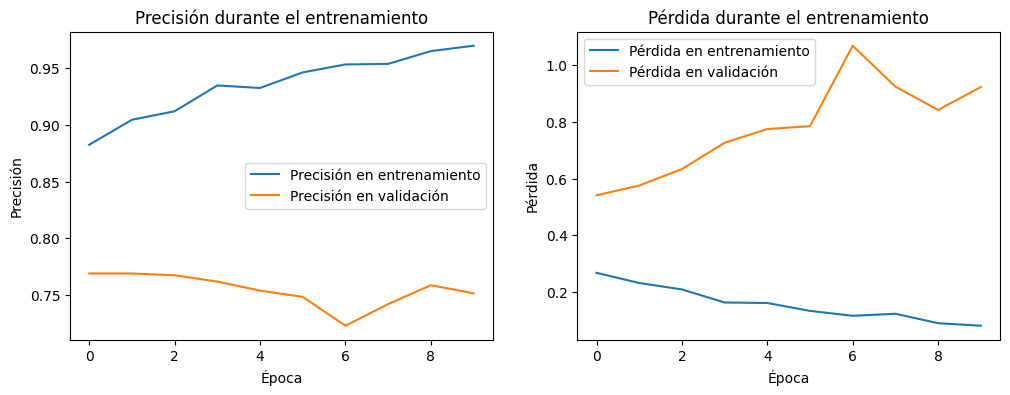

In [28]:
plt.figure(figsize=(12, 4)) ###grafica de precision durante entrenamiento
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2) ##graf perdida durante entrenamiento
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
##Funciona el código?

predictions = model.predict(train_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(train_generator, axis=1)

plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(train_generator[i].squeeze(), cmap='gray')
    color = 'purple' if predicted_labels[i] == true_labels[i] else 'red'
    plt.title(f"Pred: {predicted_labels[i]}\nReal: {true_labels[i]}", color=color)
    plt.axis('off')
plt.show()

125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step


# **Elegí este filtro y realizar este código porque más adelante me gustaría mejorarlo y hacer que el código reconozca características específicas de cada clasificación (2 en este caso; perros y gatos).**